In [32]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification")

Skipping, found downloaded files in ".\quran-recitations-for-audio-classification" (use force=True to force download)


In [33]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [34]:
import torch
from torch import nn
from torch.optim import Adam
import librosa
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
from skimage.transform import resize
from pathlib import Path


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Is Cuda available?: ", torch.cuda.is_available())  # Should print: True
print(torch.cuda.get_device_name())  # Should print your GPU name

Is Cuda available?:  True
NVIDIA GeForce RTX 3060


In [37]:
base_path = Path(os.getcwd()).resolve()
data_df = pd.read_csv(base_path/"quran-recitations-for-audio-classification"/"files_paths.csv")

data_df.head()

,FilePath,Class
0,./Dataset/Mohammed_Aluhaidan/lohaidan_171.wav,Mohammed_Aluhaidan
1,./Dataset/Mohammed_Aluhaidan/lohaidan_159.wav,Mohammed_Aluhaidan
2,./Dataset/Mohammed_Aluhaidan/lohaidan_401.wav,Mohammed_Aluhaidan
3,./Dataset/Mohammed_Aluhaidan/lohaidan_367.wav,Mohammed_Aluhaidan
4,./Dataset/Mohammed_Aluhaidan/lohaidan_373.wav,Mohammed_Aluhaidan


In [38]:
data_df["FilePath"] = data_df["FilePath"].apply(lambda x: base_path / "quran-recitations-for-audio-classification" / "Dataset"/ x)

In [39]:
print(data_df["Class"].unique())
print(len(data_df["Class"].unique()))

['Mohammed_Aluhaidan' 'Yasser_Aldossary' 'Maher_Almuaiqly'
 'Nasser_Alqutami' 'AbdulBari_Althubaity' 'Bander_Balilah'
 'Ali_Alhothaify' 'Saud_Alshuraim' 'Mohammed_Ayoub' 'AbdulRahman_Alsudais'
 'Saad_Alghamdi' 'Abdullah_Albuaijan']
12


Data Shape:  (6687, 2)
Class Distribution:  Saud_Alshuraim          696
Saad_Alghamdi           688
AbdulRahman_Alsudais    648
Yasser_Aldossary        576
Maher_Almuaiqly         576
Bander_Balilah          576
Ali_Alhothaify          576
Abdullah_Albuaijan      504
Mohammed_Ayoub          480
Nasser_Alqutami         456
AbdulBari_Althubaity    456
Mohammed_Aluhaidan      455
Name: Class, dtype: int64



([<matplotlib.patches.Wedge at 0x19a4a743800>,
 [Text(1.041716547320194, 0.353308130446066, 'Saud_Alshuraim'),
  Text(0.6152835552848185, 0.9118257216135515, 'Saad_Alghamdi'),
  Text(-0.0374597965662162, 1.0993619802600134, 'AbdulRahman_Alsudais'),
  Text(-0.6293456335597216, 0.9021774068991713, 'Yasser_Aldossary'),
  Text(-1.0041840548221823, 0.4490149040297888, 'Maher_Almuaiqly'),
  Text(-1.0919917375192687, -0.13249167969970338, 'Bander_Balilah'),
  Text(-0.8676701910951611, -0.6761275319678136, 'Ali_Alhothaify'),
  Text(-0.429828059763629, -1.0125452281453082, 'Abdullah_Albuaijan'),
  Text(0.06688254216718365, -1.0979648107080915, 'Mohammed_Ayoub'),
  Text(0.5279262049567323, -0.9650357102822582, 'Nasser_Alqutami'),
  Text(0.8811510679605868, -0.6584624480043774, 'AbdulBari_Althubaity'),
  Text(1.074963798573238, -0.2333513054538053, 'Mohammed_Aluhaidan')],
 [Text(0.5682090258110148, 0.19271352569785416, '10.4%'),
  Text(0.3356092119735373, 0.49735948451648254, '10.3%'),
  Text(-0.

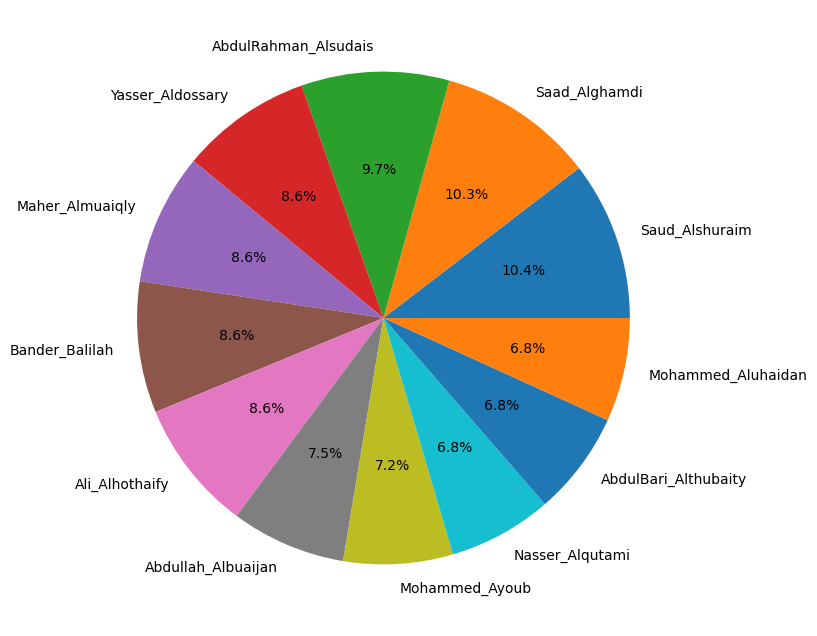

In [40]:
print("Data Shape: ", data_df.shape)
print("Class Distribution: ", data_df["Class"].value_counts())

print()

plt.figure(figsize= (8,8))

plt.pie(data_df["Class"].value_counts(), labels = data_df["Class"].value_counts().index, autopct='%1.1f%%')


In [41]:
label_encoder = LabelEncoder()
data_df["Class"] = label_encoder.fit_transform(data_df["Class"])

train = data_df.sample(frac=0.7, random_state= 7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5, random_state= 7)
test = test.drop(val.index)

print("Train shape: ", train.shape)
print("Validation shape: ", val.shape)
print("Test shape: ", test.shape)

Train shape:  (4681, 2)
Validation shape:  (1003, 2)
Test shape:  (1003, 2)


In [47]:
class CustomAudioDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe        
        self.audios = [torch.Tensor(self.get_spectogram(path)).type(torch.FloatTensor) for path in dataframe["FilePath"]]

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = int(self.dataframe.iloc[idx]["Class"])
        label = torch.tensor(label, dtype=torch.long).to(device)
        audio = self.audios[idx].unsqueeze(0).to(device)
        return audio, label
    
    def get_spectogram(self, file_path):
        sr = 22050
        duration = 5

        img_height = 128
        img_width = 256

        signal, sr = librosa.load(str(file_path), sr=sr, duration = duration)
        spec = librosa.feature.melspectrogram(y = signal, sr = sr, n_fft=2048, hop_length = 512, n_mels = 128)
        spec_db = librosa.power_to_db(spec, ref = np.max)

        spec_resized = librosa.util.fix_length(spec_db, size = (duration*sr) // 512+1)
        spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)
        return spec_resized

In [48]:
train_dataset = CustomAudioDataset(dataframe = train)
val_dataset = CustomAudioDataset(dataframe = val)
test_dataset = CustomAudioDataset(dataframe = test)

In [49]:
# Hyperparameters
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 25

In [61]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [62]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.pooling = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear((64*16*32), 4096)
        self.linear2 = nn.Linear(4096, 1024)
        self.linear3 = nn.Linear(1024, 512)
        self.output = nn.Linear(512, len(data_df["Class"].unique()))

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pooling(x)
        x = self.conv2(x)
        x = self.pooling(x)
        x = self.conv3(x)
        x = self.pooling(x)
        x = self.relu(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.dropout(x)
        
        x = self.linear2(x)
        x = self.dropout(x)
        
        x = self.linear3(x)
        x = self.dropout(x)

        x = self.output(x)
        return x


In [63]:
model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [64]:
from torchsummary import summary
summary(model, (1, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
            Conv2d-3          [-1, 32, 64, 128]           4,640
         MaxPool2d-4           [-1, 32, 32, 64]               0
            Conv2d-5           [-1, 64, 32, 64]          18,496
         MaxPool2d-6           [-1, 64, 16, 32]               0
              ReLU-7           [-1, 64, 16, 32]               0
           Flatten-8                [-1, 32768]               0
            Linear-9                 [-1, 4096]     134,221,824
          Dropout-10                 [-1, 4096]               0
           Linear-11                 [-1, 1024]       4,195,328
          Dropout-12                 [-1, 1024]               0
           Linear-13                  [-1, 512]         524,800
          Dropout-14                  [

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

import time
start_time = time.time()

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for input, labels in train_loader:
        outputs = model(input) 
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()
        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc

        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for input, labels in val_loader:
            outputs = model(input)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
            total_acc_val += val_acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))

    total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__()) * 100, 4))
    total_acc_validation_plot.append(round((total_acc_val/val_dataset.__len__()) * 100, 4))

    print(f"Epoch: {epoch + 1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)}, Train Accuracy: {round((total_acc_train/train_dataset.__len__()) * 100, 4)}, Validation Loss: {round(total_loss_val/100, 4)}, Validation Accuracy: {round((total_acc_val/val_dataset.__len__()) * 100, 4)}")
    print("="*30)

print("Training Time is: ", (round(time.time() - start_time), 4), "Seconds")

Epoch: 1/25, Train Loss: 0.3036, Train Accuracy: 97.6501, Validation Loss: 0.2876, Validation Accuracy: 92.4227
Epoch: 2/25, Train Loss: 0.3999, Train Accuracy: 97.2442, Validation Loss: 0.3148, Validation Accuracy: 91.6251
Epoch: 3/25, Train Loss: 0.3723, Train Accuracy: 97.5219, Validation Loss: 0.2884, Validation Accuracy: 92.8215
Epoch: 4/25, Train Loss: 0.1345, Train Accuracy: 99.1882, Validation Loss: 0.1831, Validation Accuracy: 95.5135
Epoch: 5/25, Train Loss: 0.1714, Train Accuracy: 98.9105, Validation Loss: 0.2778, Validation Accuracy: 92.9212
Epoch: 6/25, Train Loss: 0.0595, Train Accuracy: 99.4873, Validation Loss: 0.2335, Validation Accuracy: 95.1147
Epoch: 7/25, Train Loss: 0.3061, Train Accuracy: 98.0132, Validation Loss: 0.4857, Validation Accuracy: 91.326
Epoch: 8/25, Train Loss: 0.1817, Train Accuracy: 98.7396, Validation Loss: 0.336, Validation Accuracy: 93.0209
Epoch: 9/25, Train Loss: 0.4286, Train Accuracy: 97.2869, Validation Loss: 0.2221, Validation Accuracy: 95

In [76]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for input, labels in test_loader:
        prediction = model(input)
        acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()

        total_acc_test += acc

print(f"Total Accuracy Score is: {round((total_acc_test/test_dataset.__len__() * 100), 4)}")

Total Accuracy Score is: 96.5105


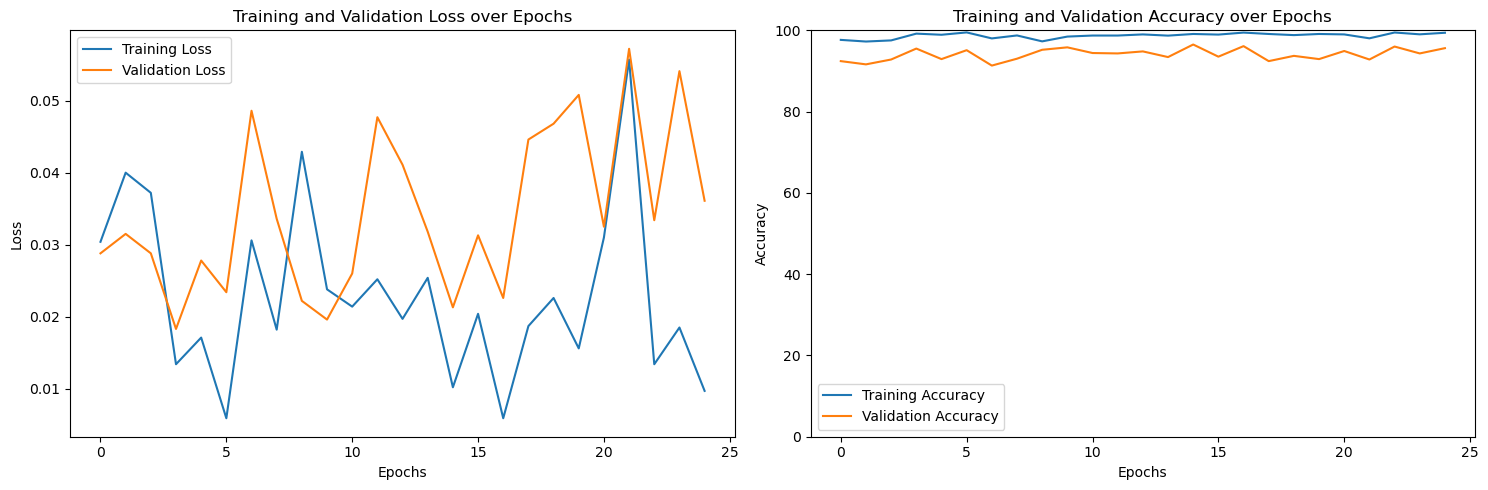

In [72]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation Loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Accuracy")
axs[1].plot(total_acc_validation_plot, label = "Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.tight_layout()
plt.show()
